# DECaLS Sky Brightness

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import speclite

import astropy.io.fits
import astropy.table
import astropy.time
import astropy.coordinates
import astropy.units as u 

import specsim.atmosphere
import specsim.simulator

from desiutil.plots import plot_sky_binned

#### Load the data from:

`https://desi.lbl.gov/trac/wiki/MilkyWayWG/SkyBrightness`

In [3]:
hdus = astropy.io.fits.open('data/decalsobs-zpt-dr3-allv2.fits')

def make_table():
    t = astropy.table.Table()
    for name in ('DATE', 'AIRMASS', 'RA', 'DEC', 'FILTER', 'SKYBR', 'MOONSEP', 'MOONPHASE', 'MOONUP', 'SUNALT', 
                 'SUNSEP', 'TRANSP', 'EXPTIME', 'ZD', 'SEEING', 'SKYSIG', 'DEPTH'):
        values = hdus[1].data[name].reshape(-1)
        t[name] = astropy.table.Column(values)
    t['MOONFRAC'] = t['MOONPHASE']
    t['MOONPHASE'] = np.arccos(2 * t['MOONFRAC'] - 1.) / np.pi
    return t

t = make_table()

In [4]:
# Only keep values with airmass != 0.0
keep_airmass = t['AIRMASS'] != 0.0
t = t[keep_airmass]

#### Get moon (alt, az) positions

In [5]:
time = astropy.time.Time(t['DATE'], format='jd')
location = astropy.coordinates.EarthLocation.from_geodetic(
    lat='-30d10m10.78s', lon='-70d48m23.49s', height=2241.4*u.m)

moon_position = astropy.coordinates.get_moon(time, location)
moon_ra = moon_position.ra.value
moon_dec = moon_position.dec.value
moon_position_altaz = moon_position.transform_to(astropy.coordinates.AltAz(obstime=time, location=location))
moon_alt = moon_position_altaz.alt.value
moon_az = moon_position_altaz.az.value

#### Get separation between pointing and moon

In [6]:
# From: http://spiff.rit.edu/classes/phys373/lectures/radec/radec.html
def separation(ra1, dec1, ra2, dec2):
    pi2 = np.radians(90)
    alpha = np.cos(np.radians(ra1)-np.radians(ra2))
    first = np.cos(pi2-np.radians(dec1))*np.cos(pi2-np.radians(dec2))
    second = np.sin(pi2-np.radians(dec1))*np.sin(pi2-np.radians(dec2))*alpha
    return np.arccos(first+second)*180/np.pi

# Fix moon position at (ra=200, dec=10)
separation_angle_fixed = separation(t['RA'], t['DEC'], ra2=200, dec2=10)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init_

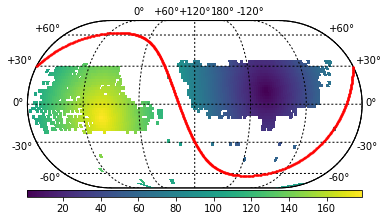

In [9]:
plot_sky_binned(t['RA'], t['DEC'], data=separation_angle_fixed);

Moon zenith = 21.2123097600646
Moon az = 307.7610505205105
Moon phase = 0.1279950421647107


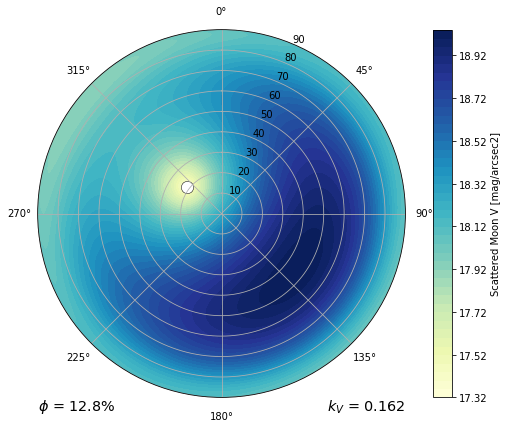

In [28]:
moon_zenith = 90. - moon_alt
moonphase = t['MOONPHASE']

print('Moon zenith = {}\nMoon az = {}\nMoon phase = {}'.format(moon_zenith[0], moon_az[0], 
                                                               moonphase[0]))
specsim.atmosphere.plot_lunar_brightness(moon_zenith[0] * u.deg, moon_az[0] * u.deg, 
                                        moonphase[0]);

Moon zenith = 97.31020505344284
Moon az = 100.50042909532662
Moon phase = 0.0975598778666546


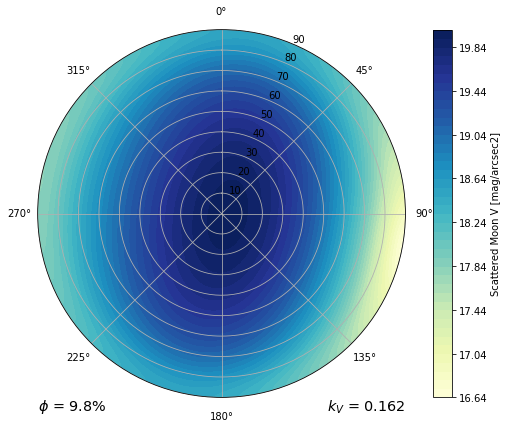

In [29]:
print('Moon zenith = {}\nMoon az = {}\nMoon phase = {}'.format(moon_zenith[300], moon_az[300], 
                                                               moonphase[300]))
specsim.atmosphere.plot_lunar_brightness(moon_zenith[300] * u.deg, moon_az[300] * u.deg, 
                                        moonphase[300]);

#### Calculate separation angle for all moon positions

In [7]:
separation_angle = separation(t['RA'], t['DEC'], ra2=moon_ra, dec2=moon_dec)

#### Select individual filters

In [8]:
sel_g = (t['FILTER'] == 'g') & (moon_alt > 10.)
sel_r = (t['FILTER'] == 'r') & (moon_alt > 10.)
sel_z = (t['FILTER'] == 'z') & (moon_alt > 10.)

#### Initialize the DESI simulator

In [9]:
sky_model = specsim.simulator.Simulator('desi').atmosphere

0.73832690584 3565.3083654708 3569.0 190
0.673101144339 5621.634494278306 5625.0 20750
0.813769768376 7430.931151158121 7435.0 38850


In [18]:
def get_sky_brightness(band):
    
    filter_response = speclite.filters.load_filter('decam2014-{}'.format(band))
    
    if band == 'g':
        cut = sel_g
    elif band == 'r':
        cut = sel_r
    elif band == 'z':
        cut = sel_z
        
    nrows = len(t[cut])
    sky_brightness = np.empty(nrows, dtype=float)

    for i in range(nrows):
        sky_model.airmass = t['AIRMASS'][cut][i]
        sky_model.moon.moon_phase = t['MOONPHASE'][cut][i]
        sky_model.moon.moon_zenith = (90. - moon_alt[cut][i]) * u.deg
        sky_model.moon.separation_angle = separation_angle[cut][i] * u.deg
        scattered_moon = (sky_model.surface_brightness * u.arcsec ** 2).to(
            u.erg / (u.Angstrom * u.cm ** 2 * u.s))
        moon_flux, sky_wlen = filter_response.pad_spectrum(scattered_moon, sky_model._wavelength)
        sky_brightness[i] = filter_response.get_ab_maggies(moon_flux, sky_wlen)

    return sky_brightness

In [19]:
sb_g = get_sky_brightness('g')
sb_r = get_sky_brightness('r')
sb_z = get_sky_brightness('z')

In [11]:
sb_g_moon = get_sky_brightness('g')
sb_r_moon = get_sky_brightness('r')
sb_z_moon = get_sky_brightness('z')

#### Convert fluxes to magnitudes

In [12]:
def flux_to_mag(flux):
    return 22.5 - 2.5*np.log10(flux*10**9)

In [20]:
sb_g_mag = flux_to_mag(sb_g)
sb_r_mag = flux_to_mag(sb_r)
sb_z_mag = flux_to_mag(sb_z)

#### Make cuts on transparency and moon altitude

Transparency is the fraction of the expected light that reaches us.

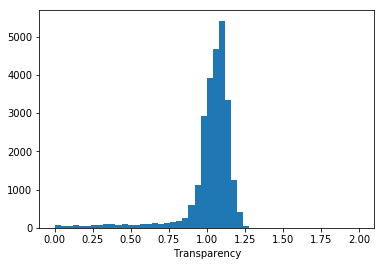

In [46]:
plt.hist(t['TRANSP'], bins=50, range=(0, 2))
plt.xlabel('Transparency')
plt.show()

In [16]:
gtransp = (t['TRANSP'][sel_g] > .75) & (t['TRANSP'][sel_g] < 1.3)
rtransp = (t['TRANSP'][sel_r] > .75) & (t['TRANSP'][sel_r] < 1.3)
ztransp = (t['TRANSP'][sel_z] > .75) & (t['TRANSP'][sel_z] < 1.3)

In [56]:
gsun_alt = t['SUNALT'][sel_g][gtransp] <= -15.
rsun_alt = t['SUNALT'][sel_r][rtransp] <= -15.
zsun_alt = t['SUNALT'][sel_z][ztransp] <= -15.

In [24]:
gmoon_alt = moon_alt[sel_g][gtransp]
rmoon_alt = moon_alt[sel_r][rtransp]
zmoon_alt = moon_alt[sel_z][ztransp]

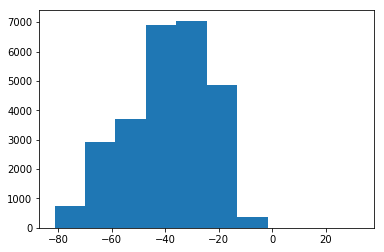

In [36]:
plt.hist(t['SUNALT']);

In [57]:
print(len(t['SKYBR'][sel_g][gtransp]), len(t['SKYBR'][sel_g][gtransp][gsun_alt]))
print(len(t['SKYBR'][sel_r][rtransp]), len(t['SKYBR'][sel_r][rtransp][rsun_alt]))
print(len(t['SKYBR'][sel_z][ztransp]), len(t['SKYBR'][sel_z][ztransp][zsun_alt]))

813 765
2029 1911
6067 5879


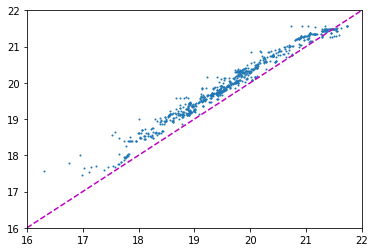

In [58]:
plt.scatter(t['SKYBR'][sel_g][gtransp][gsun_alt], sb_g_mag[gtransp][gsun_alt], s=1)
plot(np.linspace(16,25,20), np.linspace(16,25,20), ls='--', c='m')
plt.xlim(16,22)
plt.ylim(16,22)
plt.show()

In [32]:
def plot_moon_brightness(filename=None):
    
    measured_sky = np.asarray(t['SKYBR'])
        
    vmin_g = np.percentile(gmoon_alt, 5)
    vmax_g = np.percentile(gmoon_alt, 95)
    
    vmin_r = np.percentile(rmoon_alt, 5)
    vmax_r = np.percentile(rmoon_alt, 95)
    
    vmin_z = np.percentile(zmoon_alt, 5)
    vmax_z = np.percentile(zmoon_alt, 95)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))
    
    im1 = ax1.scatter(measured_sky[sel_g][gtransp], sb_g_mag[gtransp], 
            s=3, c=gmoon_alt, vmin=vmin_g, vmax=vmax_g)
    ax1.plot(np.linspace(16,22,20), np.linspace(16,22,20), ls='--', c='m')
    ax1.set_title('g-band DECaLS BGS sample')
    ax1.set_xlabel('Measured sky brightness (mag/sq arcsec)')
    ax1.set_ylabel('Predicted sky brightness (mag/sq arcsec)')
    ax1.set_xlim(16,22)
    ax1.set_ylim(16,22)
    cbar1 = fig.colorbar(im1, ax=ax1)
    cbar1.ax.get_yaxis().labelpad = 15
    cbar1.ax.set_ylabel('{}'.format('Moon altitude (deg)'), rotation=270)
    
    im2 = ax2.scatter(measured_sky[sel_r][rtransp], sb_r_mag[rtransp], 
            s=3, c=rmoon_alt, vmin=vmin_r, vmax=vmax_r)
    ax2.plot(np.linspace(16,21,20), np.linspace(16,21,20), ls='--', c='m')
    ax2.set_title('r-band DECaLS BGS sample')
    ax2.set_xlabel('Measured sky brightness (mag/sq arcsec)')
    ax2.set_ylabel('Predicted sky brightness (mag/sq arcsec)')
    ax2.set_xlim(16,21)
    ax2.set_ylim(16,21)
    cbar2 = fig.colorbar(im2, ax=ax2)
    cbar2.ax.get_yaxis().labelpad = 15
    cbar2.ax.set_ylabel('{}'.format('Moon altitude (deg)'), rotation=270)
    
    im3 = ax3.scatter(measured_sky[sel_z][ztransp], sb_z_mag[ztransp], 
            s=3, c=zmoon_alt, vmin=vmin_z, vmax=vmax_z)
    ax3.plot(np.linspace(16,19.5,20), np.linspace(16,19.5,20), ls='--', c='m')
    ax3.set_title('z-band DECaLS BGS sample')
    ax3.set_xlabel('Measured sky brightness (mag/sq arcsec)')
    ax3.set_ylabel('Predicted sky brightness (mag/sq arcsec)')
    ax3.set_xlim(16,19.5)
    ax3.set_ylim(16,19.5)
    cbar3 = fig.colorbar(im3, ax=ax3)
    cbar3.ax.get_yaxis().labelpad = 15
    cbar3.ax.set_ylabel('{}'.format('Moon altitude (deg)'), rotation=270)

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

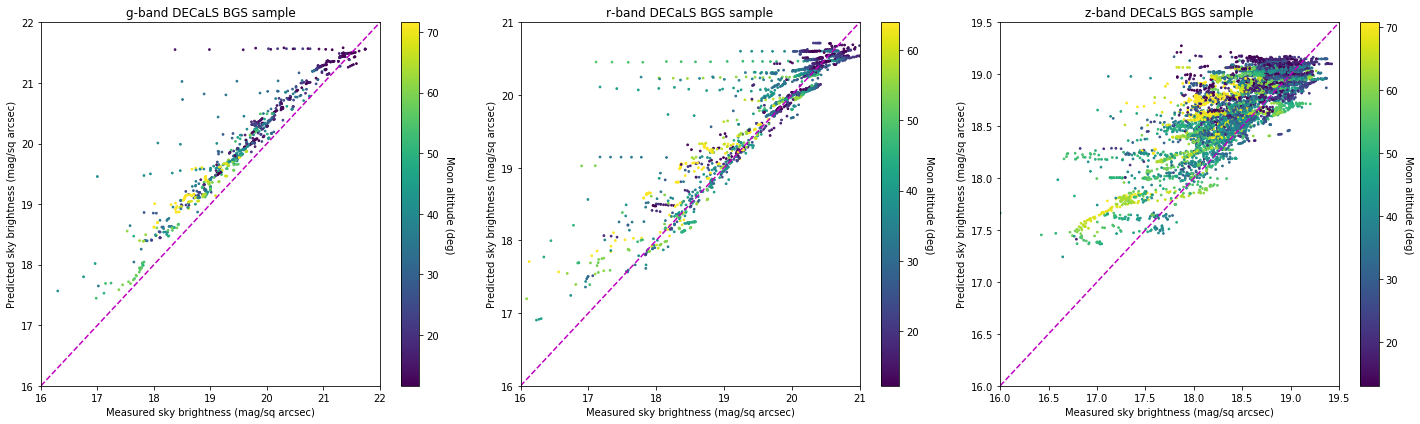

In [34]:
plot_moon_brightness('data/decals_sky_brightness.png')